<a href="https://colab.research.google.com/github/RohanHanda/NLPUsingDL/blob/main/GloveUsingTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import sys
import string
import operator

In [18]:
tf.compat.v1.disable_eager_execution()

In [2]:
sys.path.append(os.path.abspath('/content/drive/MyDrive/Colab Notebooks'))

In [3]:
from datetime import datetime
from sklearn.utils import shuffle

In [4]:
import tensorflow as tf

In [5]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cosine as cos_dist

In [6]:
from machine_learning_examples.nlp_class2.util import find_analogies

In [7]:
from machine_learning_examples.rnn_class.brown import get_sentences_with_word2idx_limit_vocab, get_sentences_with_word2idx

In [8]:
def remove_punctuation_2(s):
    return s.translate(None, string.punctuation)

def remove_punctuation_3(s):
    return s.translate(str.maketrans('','',string.punctuation))

if sys.version.startswith('2'):
    remove_punctuation = remove_punctuation_2
else:
    remove_punctuation = remove_punctuation_3

In [9]:
def my_tokenizer(s):
    s = remove_punctuation(s)
    s = s.lower() # downcase
    return s.split()

In [10]:
def get_wikipedia_data(n_files, n_vocab, by_paragraph=False):
    prefix = '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/large_files/'

    if not os.path.exists(prefix):
        print("Are you sure you've downloaded, converted, and placed the Wikipedia data into the proper folder?")
        print("I'm looking for a folder called large_files, adjacent to the class folder, but it does not exist.")
        print("Please download the data from https://dumps.wikimedia.org/")
        print("Quitting...")
        exit()

    input_files = [f for f in os.listdir(prefix) if f.startswith('enwiki') and f.endswith('txt')]

    if len(input_files) == 0:
        print("Looks like you don't have any data files, or they're in the wrong location.")
        print("Please download the data from https://dumps.wikimedia.org/")
        print("Quitting...")
        exit()

    # return variables
    sentences = []
    word2idx = {'START': 0, 'END': 1}
    idx2word = ['START', 'END']
    current_idx = 2
    word_idx_count = {0: float('inf'), 1: float('inf')}

    if n_files is not None:
        input_files = input_files[:n_files]

    for f in input_files:
        print("reading:", f)
        for line in open(prefix + f):
            line = line.strip()
            # don't count headers, structured data, lists, etc...
            if line and line[0] not in ('[', '*', '-', '|', '=', '{', '}'):
                if by_paragraph:
                    sentence_lines = [line]
                else:
                    sentence_lines = line.split('. ')
                for sentence in sentence_lines:
                    tokens = my_tokenizer(sentence)
                    for t in tokens:
                        if t not in word2idx:
                            word2idx[t] = current_idx
                            idx2word.append(t)
                            current_idx += 1
                        idx = word2idx[t]
                        word_idx_count[idx] = word_idx_count.get(idx, 0) + 1
                    sentence_by_idx = [word2idx[t] for t in tokens]
                    sentences.append(sentence_by_idx)

    # restrict vocab size
    sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
    word2idx_small = {}
    new_idx = 0
    idx_new_idx_map = {}
    for idx, count in sorted_word_idx_count[:n_vocab]:
        word = idx2word[idx]
        print(word, count)
        word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
    # let 'unknown' be the last token
    word2idx_small['UNKNOWN'] = new_idx
    unknown = new_idx

    assert('START' in word2idx_small)
    assert('END' in word2idx_small)
    assert('king' in word2idx_small)
    assert('queen' in word2idx_small)
    assert('man' in word2idx_small)
    assert('woman' in word2idx_small)

    # map old idx to new idx
    sentences_small = []
    for sentence in sentences:
        if len(sentence) > 1:
            new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
            sentences_small.append(new_sentence)

    return sentences_small, word2idx_small

In [28]:
class glove:
  def __init__(self,D,V,context_sz):
    self.D = D
    self.V = V
    self.context_sz = context_sz
  def fit(self, sentences, cc_matrix = None,epochs = 10, learning_rate = 1e-4, reg=0.1,xmax=100,alpha=0.75):
    t0 = datetime.now()
    V = self.V
    D = self.D
    if not os.path.exists(cc_matrix):
      X = np.zeros((V,V))
      N = len(sentences)
      print("Number of sentences to process: ",N)
      it = 0
      for sentence in sentences:
        it+=1
        if it%10000==0:
          print("Processed: ",it,"/",N)
        n = len(sentence)
        for i in range(n):
          wi = sentence[i]
          start = max(0,i-self.context_sz)
          end = min(n,i+self.context_sz)

          if i-self.context_sz<0:
            points = 1.0/(i+1)
            X[wi,0]+=points
            X[0,wi]+=points
          if i+self.context_sz>n:
            points = 1.0/(n-i)
            X[wi,1]+=points
            X[1,wi]+=points
          for j in range(start,i):
            wj = sentence[j]
            points = 1.0/(i-j)
            X[wi,wj]+=points
            X[wj,wi]+=points
          for j in range(i+1,end):
            wj = sentence[j]
            points = 1.0/(j-i)
            X[wi,wj]+=points
            X[wj,wi]+=points
      np.save(cc_matrix,X)
    else:
      X = np.load(cc_matrix)
    print("Max in X: ",X.max())
    fX = np.zeros((V,V))
    fX[X<xmax] = (X[X<xmax]/float(xmax))**alpha
    fX[X>=xmax] = 1
    print("Max in fX: ",fX.max())
    logX = np.log(X+1)
    print("Max in logX: ",logX.max())
    print("Time to build co-occurence matrix: ",datetime.now()-t0)

    W = np.random.rand(V,D)/np.sqrt(V+D)
    b=np.zeros(V)
    U = np.random.rand(V,D)/np.sqrt(V+D)
    c = np.zeros(V)
    mu = logX.mean()

    tfW = tf.Variable(W.astype(np.float32))
    tfb = tf.Variable(b.reshape(V,1).astype(np.float32))
    tfU = tf.Variable(U.astype(np.float32))
    tfc = tf.Variable(c.reshape(1,V).astype(np.float32))
    tfLogX = tf.compat.v1.placeholder(tf.float32,shape=(V,V))
    tffX = tf.compat.v1.placeholder(tf.float32,shape=(V,V))

    delta = tf.matmul(tfW,tf.transpose(tfU)) + tfb + tfc + mu - tfLogX
    cost = tf.reduce_sum(tffX*delta*delta)
    regularized_cost = cost
    for param in (tfW,tfU):
      regularized_cost += reg*tf.reduce_sum(param*param)

    train_op = tf.compat.v1.train.MomentumOptimizer(learning_rate, momentum = 0.9).minimize(regularized_cost)

    init = tf.compat.v1.global_variables_initializer()
    session = tf.compat.v1.InteractiveSession()
    session.run(init)

    costs = []
    sentences_indexes = range(len(sentences))
    for epoch in range(epochs):
      c, _ = session.run((cost,train_op),feed_dict={tfLogX:logX,tffX:fX})
      print("Epoch: ",epoch,"Cost: ",c)
      costs.append(c)

    self.W, self.U = session.run([tfW,tfU])
    plt.plot(costs)
    plt.show()
  def save(self,fn):
    arrays = [self.W,self.U.T]
    np.savez(fn,*arrays)


In [20]:
def main(we_file,w2i_file,use_brown = True, n_files = 50):
  if use_brown:
    cc_matrix = 'cc_matrix_brown.npy'
  else:
    cc_matrix = 'cc_matrix_%s.npy'%n_files
  if os.path.exists(cc_matrix):
    with open(w2i_file) as f:
      word2idx = json.load(f)
    sentences = []
  else:
    if use_brown:
      keep_words = set(['king','man','woman','france','paris','london','rome','italy','britain','england','french','english','japanese','japan','chinese','italian','australia','australian','december','november','june','january','february','march','april','may','june','july','august','september','october',])
      sentences,word2idx = get_sentences_with_word2idx_limit_vocab(n_vocab = 5000, keep_words = keep_words)
    else:
      sentences,word2idx = get_wikipedia_data(n_files = n_files, n_vocab = 2000)
    with open(w2i_file, 'w') as f:
      json.dump(word2idx, f)
  V = len(word2idx)
  model = glove(100,V,10)
  model.fit(sentences,cc_matrix, epochs = 200)
  model.save(we_file)


Max in X:  24402778.09316157
Max in fX:  1.0
Max in logX:  17.01020758103835
Time to build co-occurence matrix:  0:00:00.333815
Epoch:  0 Cost:  4044638.5
Epoch:  1 Cost:  2011261.1
Epoch:  2 Cost:  666065.0
Epoch:  3 Cost:  1283229.2
Epoch:  4 Cost:  2330622.5
Epoch:  5 Cost:  2129273.5
Epoch:  6 Cost:  1170059.2
Epoch:  7 Cost:  818824.25
Epoch:  8 Cost:  1223191.6
Epoch:  9 Cost:  1470333.8
Epoch:  10 Cost:  1102793.0
Epoch:  11 Cost:  672391.1
Epoch:  12 Cost:  778649.9
Epoch:  13 Cost:  1111059.0
Epoch:  14 Cost:  1001260.9
Epoch:  15 Cost:  628277.56
Epoch:  16 Cost:  583834.5
Epoch:  17 Cost:  809007.44
Epoch:  18 Cost:  852169.75
Epoch:  19 Cost:  644179.0
Epoch:  20 Cost:  509519.8
Epoch:  21 Cost:  598487.5
Epoch:  22 Cost:  701781.6
Epoch:  23 Cost:  634832.1
Epoch:  24 Cost:  504191.16
Epoch:  25 Cost:  488226.9
Epoch:  26 Cost:  563603.4
Epoch:  27 Cost:  582522.2
Epoch:  28 Cost:  510433.2
Epoch:  29 Cost:  451759.62
Epoch:  30 Cost:  472502.6
Epoch:  31 Cost:  513609.25


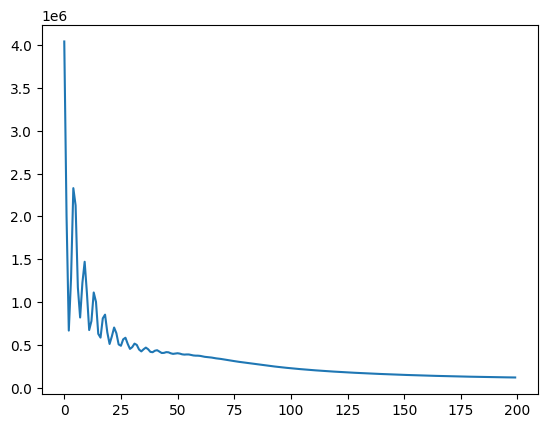

** concat: True
** concat: False
closest match by euclidean distance: queen
king - man = queen - woman
closest match by cosine distance: queen
king - man = queen - woman
closest match by euclidean distance: ireland
france - paris = ireland - london
closest match by cosine distance: ireland
france - paris = ireland - london
closest match by euclidean distance: italy
france - paris = italy - rome
closest match by cosine distance: spain
france - paris = spain - rome
closest match by euclidean distance: berlin
paris - france = berlin - italy
closest match by cosine distance: berlin
paris - france = berlin - italy
closest match by euclidean distance: england
france - french = england - english
closest match by cosine distance: england
france - french = england - english
closest match by euclidean distance: china
japan - japanese = china - chinese
closest match by cosine distance: china
japan - japanese = china - chinese
closest match by euclidean distance: italy
japan - japanese = italy - i

In [29]:
we = 'glove_model_50.npz'
w2i = 'glove_word2idx_50.json'
main(we,w2i,use_brown=False)
npz = np.load(we)
W1 = npz['arr_0']
W2 = npz['arr_1']
with open(w2i) as f:
  word2idx = json.load(f)
  idx2word = {i:w for w,i in word2idx.items()}

for concat in (True, False):
    print("** concat:", concat)

    if concat:
        We = np.hstack([W1, W2.T])
    else:
        We = (W1 + W2.T) / 2


find_analogies('king', 'man', 'woman', We, word2idx, idx2word)
find_analogies('france', 'paris', 'london', We, word2idx, idx2word)
find_analogies('france', 'paris', 'rome', We, word2idx, idx2word)
find_analogies('paris', 'france', 'italy', We, word2idx, idx2word)
find_analogies('france', 'french', 'english', We, word2idx, idx2word)
find_analogies('japan', 'japanese', 'chinese', We, word2idx, idx2word)
find_analogies('japan', 'japanese', 'italian', We, word2idx, idx2word)
find_analogies('japan', 'japanese', 'australian', We, word2idx, idx2word)
find_analogies('december', 'november', 'june', We, word2idx, idx2word)
